# Analyse des données

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()

%matplotlib inline
%run '3 - Préparation.ipynb'

Dans cette partie on se familiariser avec les données pour voire si des relations évidentes émerges. On veut aussi créer des outils d'aide à la décision.

On suivra le cheminement d'un joueur débutant en TTFL c'est à dire les questions qu'il se pose pour faire ses premiers picks.
La première question à se poser, la plus naturelle puisqu'on choisit un joueur pour ses performances, quel est le joueur le plus performant de la ligue.
Le score TTFL, qui est précisément ce qui nous interesse, nous falicite grandement la tâche, il fournit 1 critère quantifiable pour classer les joueurs.

In [2]:
df = players_id2name(score_df(pd.read_csv('../data/boxscore_2019.csv')))

In [3]:
df.sample(3)

,SEASON_ID,PLAYER_ID,NAME,GAME_ID,GAME_DATE,TEAM,ADV,HOME,WIN,PTS,REB,AST,STL,BLK,FGM,FTM,FG3M,TOV,FGF,FG3F,FTF,BONUS,MALUS,SCORE
19002,22019,1628984,Devonte' Graham,21900097,2019-11-05,CHA,IND,True,True,35,4,6,3,0,10,11,4,2,11,5,4,73,22,51
23945,22019,1629744,Matt Thomas,21900956,2020-03-08,TOR,SAC,False,True,1,1,0,0,0,0,1,0,0,2,2,1,3,5,-2
15516,22019,1628366,Lonzo Ball,21900319,2019-12-05,NOP,PHX,True,False,20,6,11,3,2,6,4,4,7,3,1,0,56,11,45


## 1 - Quels sont les joueurs les plus performants de la ligue ?

In [4]:
# Classement des joueurs en fonction de leur meilleurs performances
df.groupby('NAME').SCORE.max().sort_values(ascending=False)  \
                                    .head(5)  \
                                    .to_frame()

,SCORE
NAME,
James Harden,97
Damian Lillard,93
Kyrie Irving,89
Joel Embiid,88
Khris Middleton,87


In [5]:
# Classement des joueurs selon leur moyenne de score
df.groupby('NAME').SCORE.mean().sort_values(ascending=False) \
                                .head(5) \
                                .to_frame()

,SCORE
NAME,
Giannis Antetokounmpo,49.513889
James Harden,48.337500
Anthony Davis,45.638554
Luka Doncic,44.298507
Karl-Anthony Towns,43.342857


Première observation, la moyenne la plus haute ne dépasse pas 50 pts TTFL, quand la 5e meilleure performance est à 87 points. 
Le score TTFL semble donc être assez volatile.

In [6]:
top_players = df.groupby('NAME').SCORE.mean().sort_values(ascending=False) \
                                                .head(50) \
                                                .to_frame() \
                                                .index

df[df.NAME.isin(top_players)].groupby('NAME').SCORE.std().describe()

count    50.000000
mean     14.184934
std       2.451366
min      10.328252
25%      12.561307
50%      13.582151
75%      15.544817
max      21.452273
Name: SCORE, dtype: float64

Parmi les 50 joueurs aux meilleures moyennes TTFL, tous on un écart-type sur leur score de plus de 10, la moyenne est à 14. On 
comprend que les scores sont relativement dispersés. Chaque joueur n'étant selectionnable qu'une fois tous les 30 jours, il est 
d'autant plus crucial de bien savoir quand le jouer.

### Prenons Giannis Antetokounmpo comme exemple.

In [7]:
giannis=df[df.NAME == 'Giannis Antetokounmpo']

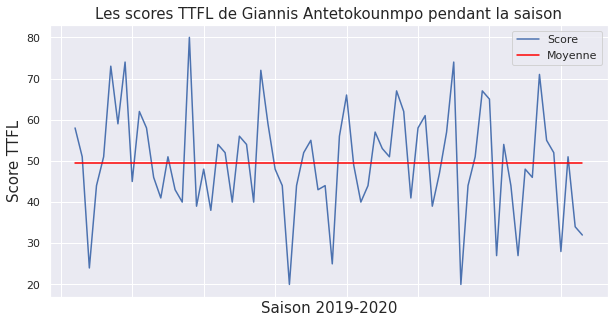

In [8]:
plt.figure(figsize=(10,5))

# Le score de Giannis au cours de la saison
plt.plot(giannis.index,giannis.SCORE,label='Score')

# Le score moyen de Giannis au cours de la saison
plt.plot(giannis.index, np.repeat(giannis.SCORE.mean(),len(giannis)), 
         color='red', linestyle='solid', label='Moyenne')

plt.title(label='Les scores TTFL de Giannis Antetokounmpo pendant la saison',
          fontsize=15)
plt.ylabel(ylabel='Score TTFL',fontsize=15)
plt.xlabel(xlabel='Saison 2019-2020',fontsize=15)

plt.tick_params(labelbottom=False) 
plt.legend()

plt.show()

Les scores de Giannis Antetokounmpo sont à la fois très dispersé autour de la moyenne et dans le temps.
Contre quelle équipe fait-il en moyenne ses meilleurs/moins bons scores ?

In [9]:
giannis.groupby('ADV').SCORE.mean().sort_values(ascending=False).head(5)

ADV
NOP    67.0
UTA    62.5
HOU    61.5
TOR    60.0
OKC    59.5
Name: SCORE, dtype: float64

Dans l'ordre Nouvelle Orléans Pelicans, Utah Jazz, Houston Rockets, Toronto Raptors et Oklahoma City Thunder.

In [10]:
giannis.groupby('ADV').SCORE.mean().sort_values().head(5)

ADV
SAC    25.000000
WAS    33.000000
BKN    33.500000
CLE    37.333333
MIA    38.571429
Name: SCORE, dtype: float64

Dans l'ordre Sacramento Kings, Washington Wizards, Brooklyn Nets, Cleveland Cavaliers et Miami Heat.

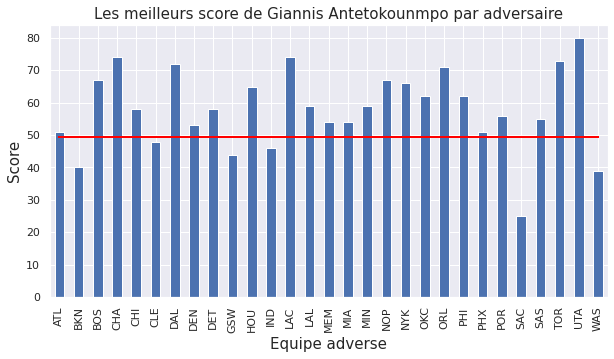

In [11]:
plt.figure(figsize=(10,5))

# Score maximum de Giannis par adversaire
giannis.groupby('ADV').SCORE.max().plot(kind='bar',figsize=(10,5),
                                        label='Score maximum')

# Score maximum de Giannis par adversaire
plt.plot(giannis.ADV, np.repeat(giannis.SCORE.mean(),len(giannis)),
         color='red', linestyle='solid', label='Score moyen')

plt.title('Les meilleurs score de Giannis Antetokounmpo par adversaire',
            fontsize=15)

plt.ylabel(ylabel='Score',fontsize=15)
plt.xlabel(xlabel='Equipe adverse',fontsize=15)

plt.show()

On peut remarquer que selon ses adversaires, le meilleur score de Giannis s'éloigne plus ou moins de sa moyenne.
La conférence Est, réputée moins forte que l'Ouest, est-elle par conséquent plus favorable au gros score pour notre joueur ?

In [12]:
Conference={'ATL':'East', 'BKN':'East', 'BOS':'East', 'CHA':'East',
            'CHI':'East', 'CLE':'East', 'DAL':'West', 'DEN':'West',
            'DET':'East', 'GSW':'West', 'HOU':'West', 'IND':'East',
            'LAC':'West', 'LAL':'West', 'MEM':'West', 'MIA':'East',
            'MIL':'East', 'MIN':'East', 'NOP':'West', 'NYK':'East',
            'OKC':'West', 'ORL':'East', 'PHI':'East', 'PHX':'West',
            'POR':'West', 'SAC':'West', 'SAS':'West', 'TOR':'East',
            'UTA':'West', 'WAS':'East'}

In [13]:
giannis_mean = pd.DataFrame(giannis.groupby('ADV').SCORE.mean())
giannis_mean = giannis_mean.assign(ADV_CONF=giannis_mean.index.map(Conference))
giannis_mean.sort_values('ADV_CONF', inplace=True)

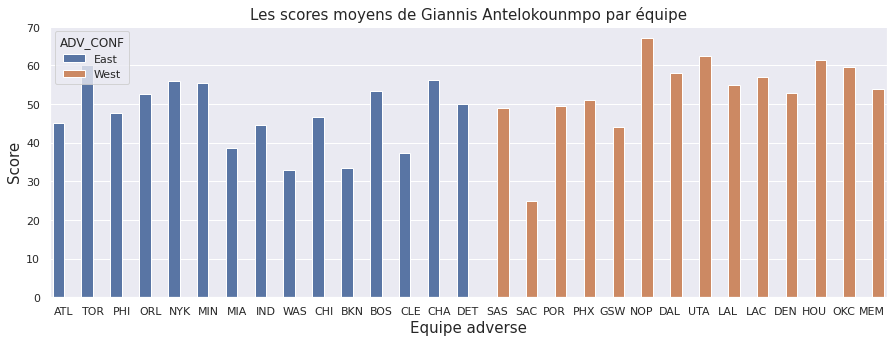

In [14]:
sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x=giannis_mean.index, y = giannis_mean.SCORE,
            hue=giannis_mean.ADV_CONF)

plt.title('Les scores moyens de Giannis Antelokounmpo par équipe',
         fontsize=15)

plt.ylabel(ylabel='Score',fontsize=15)
plt.xlabel(xlabel='Equipe adverse',fontsize=15)

plt.show()

Même si l'on se restreint aux 30, 40 meilleurs joueurs, il est long et fastidieux de se livre à cette analyse pour comparer joueur. 
Peut être qu'en regardant directement aux niveaux des équipes, certaines sont particulièrement douées pour contenir le score de ses adversaires.

## Contre quelle équipe est-il le plus difficle de mettre bcp de points ?

In [15]:
df.groupby('ADV').SCORE.mean().sort_values(ascending=False).head(5).to_frame()

,SCORE
ADV,
WAS,18.366667
ATL,18.338959
MIN,17.985141
NOP,17.596282
POR,17.498199


In [16]:
df.groupby('ADV').SCORE.mean().sort_values().head(5).to_frame()

,SCORE
ADV,
TOR,15.119774
MIL,15.184685
LAL,15.523859
LAC,15.713187
BOS,15.725191


L'écart de moyenne entre le min et le max nous laisse penser que cette observation n'est pas pertinente. Puisque le but du jeu est de choisir le joueur qui fera le meilleur score de la soirée, on se concentre sur le meilleur score dans chaque équipe. 

On va construire un tableau double entrée qui contiendra les meilleurs scores TTFL, pour chaque confrontation.

### Construction de la ligne pour un équipe (les Sacramento Kings)

In [17]:
sacremento = pd.DataFrame(df[df.TEAM=='SAC'].groupby('ADV').SCORE.max()) \
                                            .rename(columns={'SCORE':'SAC'})

sacremento = sacremento.transpose()
sacremento['SAC'] = 0

In [18]:
sacremento

ADV,ATL,BKN,BOS,CHA,CHI,DAL,DEN,DET,GSW,HOU,IND,LAC,LAL,MEM,MIA,MIL,MIN,NOP,NYK,OKC,ORL,PHI,PHX,POR,SAS,TOR,UTA,WAS,SAC
SAC,39,36,51,35,40,52,47,34,43,46,40,55,41,52,35,34,61,55,50,35,60,35,54,50,55,41,36,44,0


### Généralisation à toutes les équipes

In [19]:
# Fonction qui calcule pour une équipe
def best_score_against(df, team):
    global cross
    df = pd.DataFrame(df[df.TEAM == team].groupby('ADV').SCORE.max()) \
                                        .rename(columns={'SCORE':team.values[0]})

    df = df.transpose()
    df[team] = 0
    
    cross=pd.concat([cross, df])

# Matrice principale
cross=pd.DataFrame()
        
df.groupby('TEAM').apply(lambda df: best_score_against(df, df.TEAM))
cross = cross.reindex(sorted(cross.columns), axis=1).fillna(0)

In [20]:
# Fonction qui affiche la heatmap

def heatmap(cross):
    values = cross.stack()[cross.stack() > 0]

    sns.set(rc={'figure.figsize':(15,15)})
    sns.heatmap(data=cross, vmax=values.max(), vmin=values.min(), annot=True, 
                cmap='RdYlBu_r', center=values.mean(), square=True, cbar=True)

    plt.show()

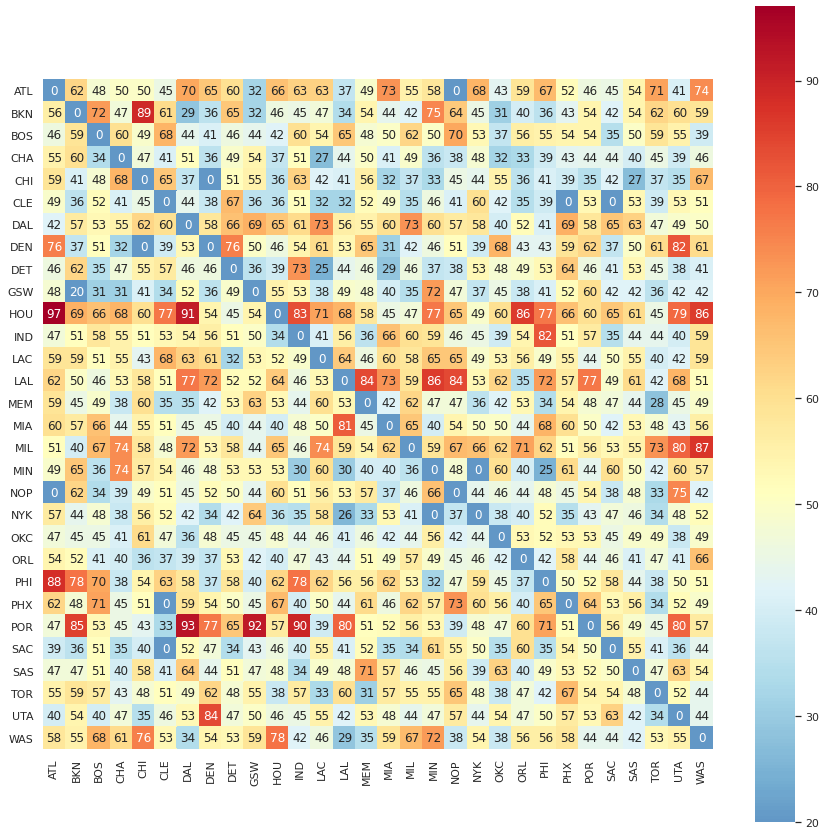

In [21]:
heatmap(cross)

Cette Heatmap étant un peu trop dense ce qui la rend peu lisible on aimerait la réduire.
Ce qui tombe bien c'est que les équipes jouent plus de match au sein de leur conférence qu'entre conférence, 
on refait donc cette Heatmap pour les conférences East et West.

In [22]:
df = df.assign(CONF=df.TEAM.map(Conference),
               ADV_CONF=df.ADV.map(Conference))

df_east = df.query("CONF=='East' & ADV_CONF=='East'")
df_west = df.query("CONF=='West' & ADV_CONF=='West'")

In [23]:
# Matrice de départ
cross=pd.DataFrame()

df_east.groupby('TEAM').apply(lambda df: best_score_against(df, df.TEAM))
cross_east = cross.reindex(sorted(cross.columns), axis=1).fillna(0)

# Matrice de départ
cross=pd.DataFrame()

df_west.groupby('TEAM').apply(lambda df: best_score_against(df, df.TEAM))
cross_west = cross.reindex(sorted(cross.columns), axis=1).fillna(0)

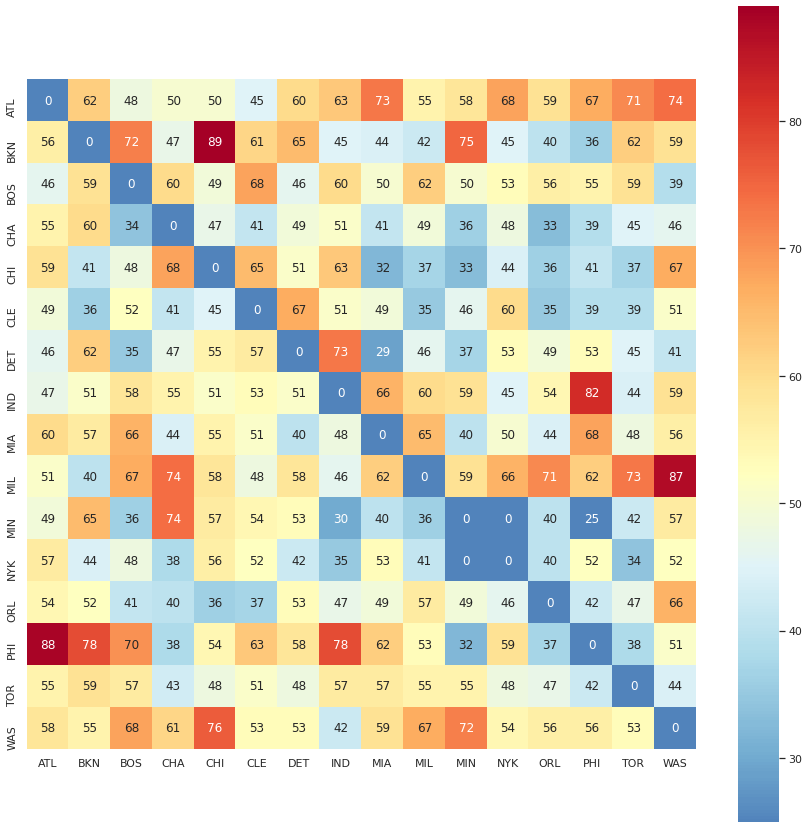

In [24]:
heatmap(cross_east)

**Lecture:** Contre Atlanta, le meilleur score TTFL d'un joueur de Boston était 46

Cette heatmap, peut nous aider à choisir contre quelle équipe jouer notre meilleur joueur de Brooklyn: Boston, Chicago 
et Minesotta peuvent être de bons choix.
Mais surement pas Philadeplhie ou Orlando.

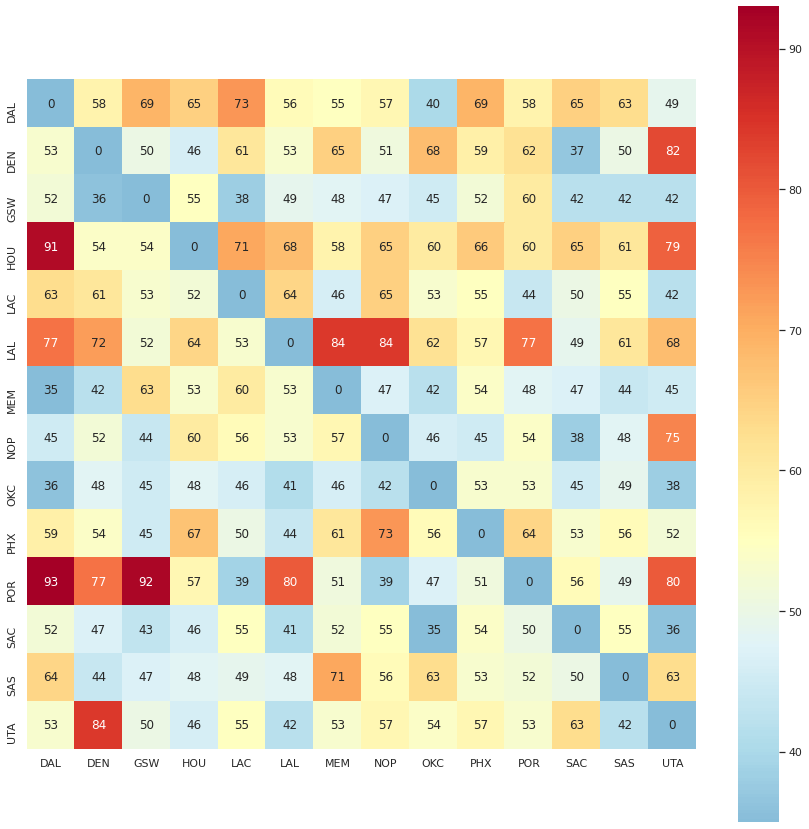

In [25]:
heatmap(cross_west)

**Lecture:** Contre Dallas, le meilleur score TTFL d'un joueur de Portland était 93

De même on prendra un joueur de Portland contre Dallas, Golden State ou Utah, mais certainement pas contre les Clippers 
ou la Nouvelle Orléans.